<a href="https://colab.research.google.com/github/SageSquash/MTechImageEnhancement/blob/master/MVSIHE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
def tanh_func(x):
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

In [2]:
def find_k_opt(pdf_x, lower, upper, mode):
    max_variance = -float('inf')
    k_opt = 0
    r_lower = 0
    r_upper = 0

    if mode == 'u':
        r_lower = -lower
        r_upper = -lower
    else:
        r_lower = 0
        r_upper = 0

    for i in range(lower, upper - 1):
        omega_0 = sum(pdf_x[lower + r_lower + 1 : i + r_lower + 1])
        omega_1 = sum(pdf_x[i + r_lower + 2 : upper + r_lower])
        mu_0 = 0
        if not (omega_0 == 0 or omega_1 == 0):
            for j in range(lower, i + 1):
                if j + r_lower + 1 >= len(pdf_x):
                    break
                mu_0 += (j * pdf_x[j + r_lower + 1]) / omega_0
            mu_1 = 0
            for j in range(i + 1, upper - 1):
                if j + r_lower + 1 >= len(pdf_x):
                    break
                mu_1 += (j * pdf_x[j + r_lower + 1]) / omega_1
            mu = (mu_0 * omega_0) + (mu_1 * omega_1)
            var_x = omega_0 * (mu_0 - mu) ** 2 + omega_1 * (mu_1 - mu) ** 2
            if var_x > max_variance:
                max_variance = var_x
                k_opt = i

    return k_opt

In [161]:
import numpy as np
from skimage import exposure
import matplotlib.pyplot as plt

def mvsihe(x, b_delta):
    L = 256
    m, n = x.shape
    hist_x = np.histogram(x, bins=np.arange(L+1))[0]
    pdf_x = hist_x / (m * n)
    k_op2 = find_k_opt(pdf_x, 0, L, 'g')

    h_sub_1 = hist_x[:k_op2 + 1]
    h_sub_2 = hist_x[k_op2 + 1:]
    
    pdf_sub_1 = h_sub_1 / h_sub_1.sum()
    pdf_sub_2 = h_sub_2 / h_sub_2.sum()

    k_op1 = find_k_opt(pdf_sub_1, 0, k_op2, 'l')
    k_op3 = find_k_opt(pdf_sub_2, k_op2 + 1, L, 'u')

    bounds1 = [0, k_op1]
    bounds2 = [k_op1, k_op2]
    bounds3 = [k_op2, k_op3]
    bounds4 = [k_op3, L - 1]

    h_sub_1 = hist_x[bounds1[0]  : bounds1[1] + 1]
    h_sub_2 = hist_x[bounds2[0] + 2 : bounds2[1] + 1]
    h_sub_3 = hist_x[bounds3[0] + 2 : bounds3[1] + 1]
    h_sub_4 = hist_x[bounds4[0] + 2 : bounds4[1] + 1]

    pdf_sub_1 = h_sub_1 / h_sub_1.sum()
    pdf_sub_2 = h_sub_2 / h_sub_2.sum()
    pdf_sub_3 = h_sub_3 / h_sub_3.sum()
    pdf_sub_4 = h_sub_4 / h_sub_4.sum()


    new_pdf_sub_1 = tanh_func(pdf_sub_1)
    new_pdf_sub_1 = new_pdf_sub_1[:, ~np.all(new_pdf_sub_1 == 0, axis=0)]

    new_pdf_sub_2 = tanh_func(pdf_sub_2)
    new_pdf_sub_2 = new_pdf_sub_2[:, ~np.all(new_pdf_sub_2 == 0, axis=0)]

    new_pdf_sub_3 = tanh_func(pdf_sub_3)
    new_pdf_sub_3 = new_pdf_sub_3[:, ~np.all(new_pdf_sub_3 == 0, axis=0)]

    new_pdf_sub_4 = tanh_func(pdf_sub_4)
    new_pdf_sub_4 = new_pdf_sub_4[:, ~np.all(new_pdf_sub_4 == 0, axis=0)]

    cdf_sub_1 = np.matmul(new_pdf_sub_1.T, np.triu(np.ones((new_pdf_sub_1.shape[0], new_pdf_sub_1.shape[0]))))
    cdf_sub_2 = np.matmul(new_pdf_sub_2.T, np.triu(np.ones((new_pdf_sub_2.shape[0], new_pdf_sub_2.shape[0]))))
    cdf_sub_3 = np.matmul(new_pdf_sub_3.T, np.triu(np.ones((new_pdf_sub_3.shape[0], new_pdf_sub_3.shape[0]))))
    cdf_sub_4 = np.matmul(new_pdf_sub_4.T, np.triu(np.ones((new_pdf_sub_4.shape[0], new_pdf_sub_4.shape[0]))))

    # # histogram equilization method

    fx_sub_1 = bounds1[0] + ((bounds1[1] - bounds1[0])) * cdf_sub_1
    fx_sub_2 = bounds2[0] + ((bounds2[1] - bounds2[0])) * cdf_sub_2
    fx_sub_3 = bounds3[0] + ((bounds3[1] - bounds3[0])) * cdf_sub_3
    fx_sub_4 = bounds4[0] + ((bounds4[1] - bounds4[0])) * cdf_sub_4


    m, n = x.shape
    out = np.zeros((m, n), dtype=np.uint8)

    # ## I am getting error in this loop


    for i in range(L):
        if i <= bounds1[1]:
            out[x == i] = (fx_sub_1[i])
        elif bounds1[1] < i <= bounds2[1]:
            out[x == i] = fx_sub_2[i - bounds2[0]]
        elif bounds2[1] < i <= bounds3[1]:
            out[x == i] = fx_sub_3[i - bounds3[0]]
        elif bounds3[1] < i <= bounds4[1]:
            out[x == i] = fx_sub_4[i - bounds4[0]]

    #############


    # # Normalisation Phase
    L_min = min(out.min())
    L_max = max(out.max())
    T_L = ((out.astype(float) - L_min) / (L_max - L_min)) * 255
    PCR_img = b_delta * T_L + (1 - b_delta) * x.astype(float)
    out = PCR_img.astype(np.uint8)


    out = np.array(out, dtype='uint8') # converting out to a numpy array
    cv2_imshow(out)
    # plt.imshow(out, cmap='gray') # display the image using imshow()
    # plt.show()

In [147]:
# import cv2

# Load image
img = cv2.imread('/content/lena.png', cv2.IMREAD_GRAYSCALE)

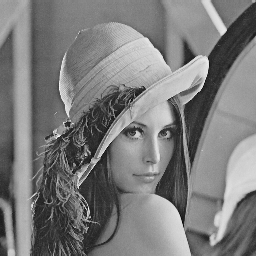

In [154]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)

In [162]:
mvsihe(img,0.6)

ValueError: ignored